# TO-DO

# Initialization

## Imports

In [1]:
from dataclasses import dataclass

import pandas as pd
import numpy as np
import random

# import plotly.io as pio
# pio.renderers.default = "vscode"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from contextlib import contextmanager

import pickle
import json
import os
from pathlib import Path
from os.path import join as pjoin
from tqdm.auto import tqdm
from copy import deepcopy
import shutil
from time import sleep

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.optim as optim

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, Checkpoint
from skorch.dataset import ValidSplit

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.size'] = 14

## Args

In [3]:
@dataclass
class Args:
    outputs_dir: str = 'analysis'

    dataset_name: str = 'ao_clevr'
    data_dir: str = '' # empty = f'data/{args.dataset_name}'
    dataset_variant: str = 'VT'
    # dataset_variant: str = 'OZ'
    
    seen_seed:int = 0

    num_split:int = 5000
    init_seed: int = 0 # for torch seeding
    
    skorch_val_ratio: float = 0.15 # split is done inside skorch training; NOT related to 'val' dataset used for calibration, hypertuning
    batch_size: int = 1024 # also for sampling multi-shifts (multi-shifted train) for MLLS training

    # only for OZ splits
    train_size: int = int(80e3)
    train_unseen_ovr_seen: float = 0
    test_size: int = int(8e3)

    # only for VisProd
    VP_mode: str = 'CE' # multi-class VisProd
    # VP_mode: str = 'BCE' # binary multi-label VisProd
    # VP_calibrate: bool = False
    VP_calibrate: bool = True
    VP_held_out_ratio: float = 0.15 # held-out taken from train for calibration (only if VP_calibrate=True)

args = Args()

In [4]:
if args.data_dir == '':
    args.data_dir = f'data/{args.dataset_name}'

if args.VP_calibrate and args.dataset_variant=='OZ':
    raise NotImplementedError("for calibration with 'OZ' variant, implement 'val' dataset (should split out of 'train')")

## Definitions

In [5]:
def torch_setup(deterministic: bool = True):
    # Setting up torch, seeding (https://pytorch.org/docs/stable/notes/randomness.html)
    # ///////////// Making pytorch deterministic (reproducible)  ////////////////////////////////////////////////////
    if deterministic:
        # read WELL: https://pytorch.org/docs/stable/notes/randomness.html
        # the order of execution is important!

        # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
        #     os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8" # may limit overall performance
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # will increase library footprint in GPU memory by approximately 24MiB
        torch.backends.cudnn.benchmark = False
        print(f"executed: torch.backends.cudnn.benchmark = False")

        torch_set_deterministic = False
        # try:
        #     torch.set_deterministic(True) # beta in torch==1.7
        #     print(f"executed torch.set_deterministic(True)")
        #     torch_set_deterministic = True
        # except Exception as ex:
        #     logger.warning(f"torch.set_deterministic(True) failed: {ex}")
        try:
            torch.use_deterministic_algorithms(True)  # beta in torch==1.8
            print(f"executed: torch.use_deterministic_algorithms(True)")
            torch_set_deterministic = True
        except Exception as ex:
            print(f"torch.use_deterministic_algorithms(True) failed: {ex}")

        if not torch_set_deterministic:  # already contained in torch.use_deterministic_algorithms(True)
            torch.backends.cudnn.deterministic = True
            print(f"executed: torch.backends.cudnn.deterministic = True")

        print(f"torch and cuda will be deterministic (after seeding)")
    else:
        torch.backends.cudnn.benchmark = True
        print(f"executed: torch.backends.cudnn.benchmark = True (torch is not determinisitc!)")
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        print('torch is using %s (%s)'%(device, torch.cuda.get_device_name(device=0)))
    else:
        print('torch is using %s'%(device))
    return device

def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed + 1000)
    torch.manual_seed(seed + 2000)
    torch.cuda.manual_seed(seed + 3000)
    print(f"completed: seeding with seed={seed} in steps of 1000 for random,np,torch,cuda")


def basic_EM(Y, Y_probs, prior_source, EM_iterations: int = 100):
    # init
    EM_results = pd.DataFrame(index=range(EM_iterations))
    EM_results.index.name = 'iteration'
    shift_probs_0 = Y_probs
    shift_probs = shift_probs_0
    prior_shift_pred = prior_source

    # eval
    shift_preds = shift_probs.argmax(axis=1)
    positives = shift_preds==Y
    # EM_results.loc[0, [f'accuracy ({label})' for label in range(args.n_labels)]] = positives.mean(axis=0)
    EM_results.loc[0, 'accuracy'] = positives.mean()
    Y_true_pos_probs = np.take_along_axis(shift_probs, Y.reshape(-1,1), axis=1)
    EM_results.loc[0, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

    # EM
    for i_EM in tqdm(range(1, 1+EM_iterations)):        
        # E-step
        shift_probs = shift_probs_0 * prior_shift_pred / prior_source
        shift_probs = (shift_probs.T / shift_probs.sum(axis=1)).T
        
        shift_preds = shift_probs.argmax(axis=1)
        
        # eval
        positives = shift_preds==Y
        EM_results.loc[i_EM, 'accuracy'] = positives.mean()
        Y_true_pos_probs = np.take_along_axis(shift_probs, Y.reshape(-1,1), axis=1)
        EM_results.loc[i_EM, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

        # M-step
        prior_shift_pred = shift_probs.mean(axis=0)
    assert (~np.isfinite(shift_probs)).sum() == 0
    return EM_results, shift_probs


def EM(Y:dict, Y_probs:dict, EM_iterations: int = 100, prior_source_phase: str = 'est. soft train',
        init_prior: str = 'source prior', n_combs: int = None,
        soft_prior: bool = True, over_update_probs: bool = False):
    """
    Y and Y_probs: dictionaries with 'train' and 'test' keys, EM adaptation is done on 'test'
    soft_prior:
        (for proper EM) True: SOFT prior_shift_pred = shift_probs.mean(axis=0)
        (for improper EM) False: HARD prior_shift_pred (calculated from hist)
    over_update_probs:
        (for proper EM) False: shift_probs = shift_probs_0 * prior_shift_pred / prior_train
        (for improper EM) True: shift_probs = shift_probs * prior_shift_pred / prior_train
    """
    
    if (not soft_prior) or over_update_probs or (prior_source_phase != 'est. soft train'):
        confirm_ui = input("confirm performing an IMPROPER EM for debugging, " \
            "(for a proper EM, set: soft_prior = True, over_update_probs = False, "\
            "prior_source_phase = 'est. soft train'): y/[n] ")
        if confirm_ui != 'y':
            raise RuntimeError("terminated by user")

    if 'est. soft' in prior_source_phase:
        Y_probs_source = Y_probs['test' if 'test' in prior_source_phase else 'train']
        prior_source = Y_probs_source.mean(axis=0)
    elif 'true' in prior_source_phase:
        Y_source = Y['test' if 'test' in prior_source_phase else 'train']
        hist = np.bincount(Y_source, minlength=n_combs)
        prior_source = hist / hist.sum()
    elif prior_source_phase == 'uniform':
        prior_source = 1/n_combs * np.ones(n_combs)
    else:
        raise NotImplementedError
    
    print(f"source prior ('{prior_source_phase}'):")
    display(prior_source)

    # init
    EM_results = pd.DataFrame(index=range(EM_iterations))
    EM_results.index.name = 'iteration'
    shift_labels = Y['test']
    shift_probs_0 = Y_probs['test']
    shift_probs = shift_probs_0

    if init_prior == 'source prior':
        prior_shift_pred = prior_source
    elif init_prior == 'uniform':
        prior_shift_pred = 1/n_combs * np.ones(n_combs)
    else:
        raise NotImplementedError

    # eval
    shift_preds = shift_probs.argmax(axis=1)
    positives = shift_preds==shift_labels
    # EM_results.loc[0, [f'accuracy ({label})' for label in range(args.n_labels)]] = positives.mean(axis=0)
    EM_results.loc[0, 'accuracy'] = positives.mean()
    # likelihood
    Y_true_pos_probs = np.take_along_axis(shift_probs, Y['test'].reshape(-1,1), axis=1)
    EM_results.loc[0, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

    # EM
    for i_EM in tqdm(range(1, 1+EM_iterations)):        
        # E-step
        if over_update_probs:
            shift_probs = shift_probs * prior_shift_pred / prior_source
        else:
            shift_probs = shift_probs_0 * prior_shift_pred / prior_source
        shift_probs = (shift_probs.T / shift_probs.sum(axis=1)).T
        
        shift_preds = shift_probs.argmax(axis=1)
        
        # eval
        positives = shift_preds==shift_labels
        EM_results.loc[i_EM, 'accuracy'] = positives.mean()
        # likelihood
        Y_true_pos_probs = np.take_along_axis(shift_probs, Y['test'].reshape(-1,1), axis=1)
        EM_results.loc[i_EM, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

        # M-step
        if soft_prior:
            prior_shift_pred = shift_probs.mean(axis=0)
        else:
            hist_shift_pred = np.bincount(shift_preds, minlength=args.n_classes_per_label * args.n_labels)
            prior_shift_pred = hist_shift_pred / hist_shift_pred.sum()

    assert (~np.isfinite(shift_probs)).sum() == 0
    return EM_results, shift_probs

## Yuval's defitions

In [6]:
if args.dataset_variant in ['VT', 'UV']:
    from typing import NamedTuple
    from pathlib import Path
    from ATTOP.data.dataset import sample_negative as ATTOP_sample_negative
    from torch.utils import data
    from COSMO_utils import temporary_random_numpy_seed


    def get_and_update_num_calls(func_ptr):
        try:
            get_and_update_num_calls.num_calls_cnt[func_ptr] += 1
        except AttributeError as e:
            if 'num_calls_cnt' in repr(e):
                get_and_update_num_calls.num_calls_cnt = defaultdict(int)
            else:
                raise

        return get_and_update_num_calls.num_calls_cnt[func_ptr]

    def categorical_histogram(data, labels_list, plot=True, frac=True, plt_show=False):
        import matplotlib.pyplot as plt
        s_counts = pd.Series(data).value_counts()
        s_frac = s_counts/s_counts.sum()
        hist_dict = s_counts.to_dict()
        if frac:
            hist_dict = s_frac.to_dict()
        hist = []
        for ix, _ in enumerate(labels_list):
            hist.append(hist_dict.get(ix, 0))

        if plot:
            pd.Series(hist, index=labels_list).plot(kind='bar')
            if frac:
                plt.ylim((0,1))
            if plt_show:
                plt.show()
        else:
            return np.array(hist, dtype='float32')

    class DataItem(NamedTuple):
        """ A NamedTuple for returning a Dataset item """
        feat: torch.Tensor
        pos_attr_id: int
        pos_obj_id: int
        neg_attr_id: int
        neg_obj_id: int
        image_fname: str


    class CompDataFromDict():
        # noinspection PyMissingConstructor
        def __init__(self, dict_data: dict, data_subset: str, data_dir: str):

            # define instance variables to be retrieved from struct_data_dict
            self.split: str = 'TBD'
            self.phase: str = 'TBD'
            self.feat_dim: int = -1
            self.objs: list = []
            self.attrs: list = []
            self.attr2idx: dict = {}
            self.obj2idx: dict = {}
            self.pair2idx: dict = {}
            self.seen_pairs: list = []
            self.all_open_pairs: list = []
            self.closed_unseen_pairs: list = []
            self.unseen_closed_val_pairs: list = []
            self.unseen_closed_test_pairs: list = []
            self.train_data: tuple = tuple()
            self.val_data: tuple = tuple()
            self.test_data: tuple = tuple()

            self.data_dir: str = data_dir

            # retrieve instance variables from struct_data_dict
            vars(self).update(dict_data)
            self.data = dict_data[data_subset]

            self.activations = {}
            features_dict = torch.load(Path(data_dir) / 'features.t7')
            for i, img_filename in enumerate(features_dict['files']):
                self.activations[img_filename] = features_dict['features'][i]

            self.input_shape = (self.feat_dim,)
            self.num_objs = len(self.objs)
            self.num_attrs = len(self.attrs)
            self.num_seen_pairs = len(self.seen_pairs)
            self.shape_obj_attr = (self.num_objs, self.num_attrs)

            self.flattened_seen_pairs_mask = self.get_flattened_pairs_mask(self.seen_pairs)
            self.flattened_closed_unseen_pairs_mask = self.get_flattened_pairs_mask(self.closed_unseen_pairs)
            self.flattened_all_open_pairs_mask = self.get_flattened_pairs_mask(self.all_open_pairs)
            self.seen_pairs_joint_class_ids = np.where(self.flattened_seen_pairs_mask)

            self.y1_freqs, self.y2_freqs, self.pairs_freqs = self._calc_freqs()
            self._just_load_labels = False

            self.train_pairs = self.seen_pairs

        def sample_negative(self, attr, obj):
            return ATTOP_sample_negative(self, attr, obj)

        def get_flattened_pairs_mask(self, pairs):
            pairs_ids = np.array([(self.obj2idx[obj], self.attr2idx[attr]) for attr, obj in pairs])
            flattened_pairs = np.zeros(self.shape_obj_attr, dtype=bool)  # init an array of False
            flattened_pairs[tuple(zip(*pairs_ids))] = True
            flattened_pairs = flattened_pairs.flatten()
            return flattened_pairs

        def just_load_labels(self, just_load_labels=True):
            self._just_load_labels = just_load_labels

        def get_all_labels(self):
            attrs = []
            objs = []
            joints = []
            self.just_load_labels(True)
            for attrs_batch, objs_batch in self:
                if isinstance(attrs_batch, torch.Tensor):
                    attrs_batch = attrs_batch.cpu().numpy()
                if isinstance(objs_batch, torch.Tensor):
                    objs_batch = objs_batch.cpu().numpy()
                joint = self.to_joint_label(objs_batch, attrs_batch)

                attrs.append(attrs_batch)
                objs.append(objs_batch)
                joints.append(joint)

            self.just_load_labels(False)
            attrs = np.array(attrs)
            objs = np.array(objs)
            return attrs, objs, joints

        def _calc_freqs(self):
            y2_train, y1_train, ys_joint_train = self.get_all_labels()
            y1_freqs = categorical_histogram(y1_train, range(self.num_objs), plot=False, frac=True)
            y1_freqs[y1_freqs == 0] = np.nan
            y2_freqs = categorical_histogram(y2_train, range(self.num_attrs), plot=False, frac=True)
            y2_freqs[y2_freqs == 0] = np.nan

            pairs_freqs = categorical_histogram(ys_joint_train,
                                                range(self.num_objs * self.num_attrs),
                                                plot=False, frac=True)
            pairs_freqs[pairs_freqs == 0] = np.nan
            return y1_freqs, y2_freqs, pairs_freqs

        def get(self, name):
            return vars(self).get(name)

        def __getitem__(self, idx):
            image_fname, attr, obj = self.data[idx]
            pos_attr_id, pos_obj_id = self.attr2idx[attr], self.obj2idx[obj]
            if self._just_load_labels:
                return pos_attr_id, pos_obj_id

            num_calls_cnt = get_and_update_num_calls(self.__getitem__)

            negative_attr_id, negative_obj_id = -1, -1  # default values
            if self.phase == 'train':
                # we set a temp np seed to override a weird issue with
                # sample_negative() at __getitem__, where the sampled pairs
                # could not be deterministically reproduced:
                # Now at each call to _getitem_ we set the seed to a 834276 (chosen randomly) + the number of calls to _getitem_
                with temporary_random_numpy_seed(834276 + num_calls_cnt):
                    # draw a negative pair
                    negative_attr_id, negative_obj_id = self.sample_negative(attr, obj)

            item = DataItem(
                feat=self.activations[image_fname],
                pos_attr_id=pos_attr_id,
                pos_obj_id=pos_obj_id,
                neg_attr_id=negative_attr_id,
                neg_obj_id=negative_obj_id,
                image_fname=image_fname,
            )
            return item

        def __len__(self):
            return len(self.data)

        def to_joint_label(self, y1_batch, y2_batch):
            return (y1_batch * self.num_attrs + y2_batch)


    def get_data_loaders(train_dataset, valid_dataset, test_dataset, batch_size,
                        num_workers=10, test_batchsize=None, shuffle_eval_set=True):
        if test_batchsize is None:
            test_batchsize = batch_size

        pin_memory = True
        if num_workers == 0:
            pin_memory = False
        print('num_workers = ', num_workers)
        print('pin_memory = ', pin_memory)
        train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                                    pin_memory=pin_memory)
        valid_loader = None
        if valid_dataset is not None and len(valid_dataset) > 0:
            valid_loader = data.DataLoader(valid_dataset, batch_size=test_batchsize, shuffle=shuffle_eval_set,
                                        num_workers=num_workers, pin_memory=pin_memory)
        test_loader = data.DataLoader(test_dataset, batch_size=test_batchsize, shuffle=shuffle_eval_set,
                                    num_workers=num_workers, pin_memory=pin_memory)
        return test_loader, train_loader, valid_loader

# Data processing

## Reading global metadata

In [7]:
meta_df = pd.read_csv(pjoin(args.data_dir, 'objects_metadata.csv'))
print(f"available samples: len(meta_df) = {len(meta_df)}")
meta_df

available samples: len(meta_df) = 180000


,image_filename,split,shape,color,material,size,pixel_coords,3d_coords,image
0,ao_clevr_cube_026006.png,cube,cube,gray,metal,small,"[52, 39, 11.845768928527832]","[-0.7997756004333496, 1.3228751420974731, 0.34...",ao_clevr_cube_026006.png
1,ao_clevr_cube_091063.png,cube,cube,gray,rubber,small,"[62, 55, 9.742987632751465]","[2.3687503337860107, -0.3344546854496002, 0.34...",ao_clevr_cube_091063.png
2,ao_clevr_cylinder_044993.png,cylinder,cylinder,brown,rubber,small,"[63, 47, 10.751688003540039]","[1.2539156675338745, 0.9125927686691284, 0.349...",ao_clevr_cylinder_044993.png
3,ao_clevr_cube_029146.png,cube,cube,brown,metal,large,"[87, 43, 10.785911560058594]","[2.821303606033325, 2.7795522212982178, 0.6999...",ao_clevr_cube_029146.png
4,ao_clevr_cube_029340.png,cube,cube,blue,metal,small,"[20, 44, 11.521142959594727]","[-2.1865415573120117, -2.1958963871002197, 0.3...",ao_clevr_cube_029340.png
...,...,...,...,...,...,...,...,...,...
179995,ao_clevr_sphere_015978.png,sphere,sphere,green,metal,large,"[26, 48, 9.729835510253906]","[-0.46921536326408386, -2.3235161304473877, 0....",ao_clevr_sphere_015978.png
179996,ao_clevr_sphere_138770.png,sphere,sphere,purple,metal,large,"[34, 51, 9.169315338134766]","[0.42953187227249146, -1.9918320178985596, 0.6...",ao_clevr_sphere_138770.png
179997,ao_clevr_sphere_008994.png,sphere,sphere,yellow,metal,small,"[57, 60, 8.973981857299805]","[2.533961057662964, -0.9791346192359924, 0.349...",ao_clevr_sphere_008994.png
179998,ao_clevr_cylinder_118260.png,cylinder,cylinder,green,rubber,small,"[15, 45, 11.007580757141113]","[-2.2124664783477783, -2.709893226623535, 0.34...",ao_clevr_cylinder_118260.png


## Building global combinations distribution (global_label_combs)

In [8]:
label_cols = ['shape', 'color']
# --------------------------------

global_label_combs = meta_df[label_cols].groupby(label_cols).size()
global_label_combs.name = 'global samples'
global_label_combs = global_label_combs.reset_index()
global_label_combs['global freq'] = global_label_combs['global samples']/global_label_combs['global samples'].sum()
global_label_combs.index.name = 'comb idx'
global_label_combs = global_label_combs.reset_index()

label_maps = {label:{} for label in label_cols}
for label in label_cols:
    label_map = label_maps[label]
    for val in global_label_combs[label].unique():
        label_map[val] = len(label_map)
display(label_maps)

for label in label_cols:
    global_label_combs[f'{label} idx'] = global_label_combs[label].map(label_maps[label])
display(global_label_combs)

assert len(label_cols) == 2
global_label_combs_pivot = global_label_combs.pivot(index=label_cols[0], columns=label_cols[1], values='global samples')
display(global_label_combs_pivot)

distinct_label_n_vals = {label: len(global_label_combs[label].unique()) for label in label_cols}
display(distinct_label_n_vals)


{'shape': {'cube': 0, 'cylinder': 1, 'sphere': 2},
 'color': {'blue': 0,
  'brown': 1,
  'cyan': 2,
  'gray': 3,
  'green': 4,
  'purple': 5,
  'red': 6,
  'yellow': 7}}

,comb idx,shape,color,global samples,global freq,shape idx,color idx
0,0,cube,blue,7520,0.041778,0,0
1,1,cube,brown,7508,0.041711,0,1
2,2,cube,cyan,7344,0.040800,0,2
3,3,cube,gray,7552,0.041956,0,3
4,4,cube,green,7346,0.040811,0,4
5,5,cube,purple,7565,0.042028,0,5
6,6,cube,red,7458,0.041433,0,6
7,7,cube,yellow,7707,0.042817,0,7
8,8,cylinder,blue,7338,0.040767,1,0
9,9,cylinder,brown,7455,0.041417,1,1


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,7520,7508,7344,7552,7346,7565,7458,7707
cylinder,7338,7455,7521,7582,7475,7513,7446,7670
sphere,7525,7430,7628,7376,7559,7476,7425,7581


{'shape': 3, 'color': 8}

## (A) Oz's splits, data

### Sampling distributions
Verifying compositional sampling is valid - each label has at least one shared combination with any other label, unseen pivot shape is the same as global pivot - no empty columns or rows.

In [9]:
if args.dataset_variant == 'OZ':
    assert len(label_cols) == 2 # for the pivot below used to decide if the sampling is valid

    num_split_str = str(args.num_split)
    unseen_ovr_tot = int(num_split_str[:2])/100
    data_seed = int(num_split_str[3:])

    invalid_sampling = True
    max_i_sampling = 100
    i_sampling = 0

    while invalid_sampling:
        seen_label_dist = global_label_combs.sample(frac=unseen_ovr_tot,
            random_state=max_i_sampling*data_seed+i_sampling)
        seen_label_dist_pivot = seen_label_dist.pivot(index=label_cols[0], columns=label_cols[1], values='global samples')
        
        if seen_label_dist_pivot.shape == global_label_combs_pivot.shape:
            invalid_sampling = False
            print(f"succeeded sampling with all unique label values in iteration {i_sampling}")
        i_sampling += 1
        if i_sampling >= max_i_sampling:
            print(f"reached max iterations ({max_i_sampling}) without success in sampling with all unique label values ")
            break

In [10]:
if args.dataset_variant == 'OZ':
    unseen_combs_idx = set(global_label_combs.index) - set(seen_label_dist.index)
    unseen_label_dist = global_label_combs.loc[list(unseen_combs_idx)]
    assert len(set(seen_label_dist.index) & set(unseen_label_dist.index)) == 0

    label_dists_df = global_label_combs.copy()
    label_dists_df.loc[seen_label_dist.index, 'train prob'] = 1/len(seen_label_dist)
    label_dists_df.loc[seen_label_dist.index, 'state'] = 'seen'
    label_dists_df.loc[unseen_label_dist.index, 'train prob'] =\
        args.train_unseen_ovr_seen / len(seen_label_dist)
    label_dists_df.loc[unseen_label_dist.index, 'state'] = 'unseen'
    label_dists_df['train prob'] = label_dists_df['train prob'] / label_dists_df['train prob'].sum()
    label_dists_df['test prob'] =  1/len(label_dists_df)
    display(label_dists_df)

### Sampling samples

In [11]:
if args.dataset_variant == 'OZ':
    meta_df_ = meta_df.merge(label_dists_df, on=label_cols)
    meta_df_ = meta_df_.sample(frac=1, random_state=data_seed)

    for i_row in range(len(label_dists_df)):
        row = label_dists_df.iloc[i_row]
        comb_idx = row['comb idx']
        comb_samples = meta_df_.query(f"`comb idx` == {comb_idx}")

        # selecting train
        n_samples_train = round(args.train_size * row['train prob'])
        assert n_samples_train <= len(comb_samples)
        meta_df_.loc[comb_samples.index[:n_samples_train], 'phase'] = 'train'

        # selecting test
        n_samples_test = round(args.test_size * row['test prob'])
        assert n_samples_test <= len(comb_samples) - n_samples_train
        meta_df_.loc[comb_samples.index[
            n_samples_train: n_samples_train+n_samples_test], 'phase'] = 'test'

### Verifying

In [12]:
if args.dataset_variant == 'OZ':
    for phase in ['train', 'test']:
        label_dists_df[f'{phase} samples'] = meta_df_.query(f"phase == '{phase}'")['comb idx'].value_counts()
        label_dists_df[f'{phase} freq'] = label_dists_df[f'{phase} samples']/label_dists_df[f'{phase} samples'].sum()
    display(label_dists_df)

### Preparing data

In [13]:
if args.dataset_variant == 'OZ':
    features_dict = torch.load(pjoin(args.data_dir, 'features.t7'))
    features_dict_ = {file:tensor for file, tensor in zip(
        features_dict['files'], features_dict['features'])}

    idx = 5
    assert torch.equal(features_dict_[features_dict['files'][idx]], features_dict['features'][idx])
    del features_dict

In [14]:
if args.dataset_variant == 'OZ':
    X, Y_comb = {}, {}
    Y_shape, Y_color = {}, {}
    Y_shape_onehot, Y_color_onehot = {}, {}
    for phase in ['train', 'test']:
        data_df = meta_df_.query(f"phase == '{phase}'")
        print(f"{phase} contains {len(data_df)} samples")

        Y_comb[phase] = data_df['comb idx'].values.astype('int64')

        Y_shape[phase] = data_df['shape idx'].values.astype('int64')
        one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(distinct_label_n_vals['shape'])])
        Y_shape_onehot[phase] = one_hot_encoder.fit_transform(data_df['shape idx'].values.reshape(-1, 1)).astype('float32') # float32 required in skorch for multi-label learning
        
        Y_color[phase] = data_df['color idx'].values.astype('int64')
        one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(distinct_label_n_vals['color'])])
        Y_color_onehot[phase] = one_hot_encoder.fit_transform(data_df['color idx'].values.reshape(-1, 1)).astype('float32') # float32 required in skorch for multi-label learning     

        X[phase] = torch.cat([features_dict_[filename].unsqueeze(0)
            for filename in data_df['image_filename']], dim=0)
    del features_dict_

## (B) Yuval's splits, dataloaders

In [15]:
if args.dataset_variant in ['VT', 'UV']:
    meta_path = Path(f"{args.data_dir}/metadata_pickles")
    random_state_path = Path(f"{args.data_dir}/np_random_state_pickles")
    # meta_path = meta_path.expanduser()

    dict_data = dict()

    for subset in ['train', 'valid', 'test']:
        metadata_full_filename = meta_path / f"metadata_{args.dataset_name}__{args.dataset_variant}_random__comp_seed_{args.num_split}__seen_seed_{args.seen_seed}__{subset}.pkl"
        dict_data[f'{subset}'] = deepcopy(pickle.load(open(metadata_full_filename, 'rb')))

    np_rnd_state_fname = random_state_path / f"np_random_state_{args.dataset_name}__{args.dataset_variant}_random__comp_seed_{args.num_split}__seen_seed_{args.seen_seed}.pkl"
    np_seed_state = pickle.load(open(np_rnd_state_fname, 'rb'))
    np.random.set_state(np_seed_state)

    datasets = {}
    for phase in ['train', 'val', 'test']:
        datasets[phase] = CompDataFromDict(dict_data[phase if phase!='val' else 'valid'],
            data_subset=f'{phase}_data', data_dir=args.data_dir)

### Preparing data

In [16]:
if args.dataset_variant in ['VT', 'UV']:
    X, Y_comb = {}, {}
    Y_shape, Y_color = {}, {}
    Y_shape_onehot, Y_color_onehot = {}, {}
    label_dists_df = global_label_combs.copy()
    for phase, dataset in datasets.items():
        dataset = datasets[phase]
        data_df = pd.DataFrame(dataset.data, columns=['filename', 'color', 'shape'])
        data_df = data_df.merge(label_dists_df, on=label_cols)
        print(f"{phase} contains {len(data_df)} samples")

        Y_comb[phase] = data_df['comb idx'].values.astype('int64')

        Y_shape[phase] = data_df['shape idx'].values.astype('int64')
        one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(distinct_label_n_vals['shape'])])
        Y_shape_onehot[phase] = one_hot_encoder.fit_transform(data_df['shape idx'].values.reshape(-1, 1)).astype('float32') # float32 required in skorch for multi-label learning
        
        Y_color[phase] = data_df['color idx'].values.astype('int64')
        one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(distinct_label_n_vals['color'])])
        Y_color_onehot[phase] = one_hot_encoder.fit_transform(data_df['color idx'].values.reshape(-1, 1)).astype('float32') # float32 required in skorch for multi-label learning

        features = dataset.activations
        X[phase] = torch.cat([features[filename].unsqueeze(0)
            for filename in data_df['filename']], dim=0)

        dist_df = data_df.groupby(label_cols).size()
        dist_df.name = f'{phase} samples'
        dist_df = dist_df.reset_index()
        dist_df[f'{phase} freq'] = dist_df[f'{phase} samples']/dist_df[f'{phase} samples'].sum()
        label_dists_df = label_dists_df.merge(dist_df, on=label_cols, how='outer')

    label_dists_df = label_dists_df.set_index('comb idx')
    label_dists_df.loc[label_dists_df['train freq'].isna(), 'state'] = 'unseen'
    label_dists_df.loc[~label_dists_df['train freq'].isna(), 'state'] = 'seen'
    
    display(label_dists_df)

train contains 80958 samples
val contains 4678 samples
test contains 7720 samples


,shape,color,global samples,global freq,shape idx,color idx,train samples,train freq,val samples,val freq,test samples,test freq,state
comb idx,,,,,,,,,,,,,
0,cube,blue,7520,0.041778,0,0,6841.0,0.084501,373,0.079735,306,0.039637,seen
1,cube,brown,7508,0.041711,0,1,6790.0,0.083871,376,0.080376,342,0.044301,seen
2,cube,cyan,7344,0.040800,0,2,NaN,NaN,5,0.001069,300,0.038860,unseen
3,cube,gray,7552,0.041956,0,3,6793.0,0.083908,405,0.086575,354,0.045855,seen
4,cube,green,7346,0.040811,0,4,6611.0,0.081660,390,0.083369,345,0.044689,seen
5,cube,purple,7565,0.042028,0,5,NaN,NaN,5,0.001069,300,0.038860,unseen
6,cube,red,7458,0.041433,0,6,NaN,NaN,5,0.001069,300,0.038860,unseen
7,cube,yellow,7707,0.042817,0,7,NaN,NaN,5,0.001069,300,0.038860,unseen
8,cylinder,blue,7338,0.040767,1,0,6658.0,0.082240,382,0.081659,298,0.038601,seen


## Analyzing

In [17]:
n_unseen = len(label_dists_df.query(f"state == 'seen'"))
n_seen = len(label_dists_df.query(f"state == 'unseen'"))
assert len(label_dists_df) == n_unseen + n_seen
print(f"n_unseen / n_total = {n_unseen} / {len(label_dists_df)} = {n_unseen/len(label_dists_df)}")

n_unseen / n_total = 12 / 24 = 0.5


In [18]:
for phase in X:
    print(f"{phase} samples:")
    # with pd.option_context('display.float_format',"{:,.4f}".format):
    #     display(label_dists_df.pivot(index=label_cols[0], columns=label_cols[1], values=f'{phase} freq'))
    with pd.option_context('display.float_format',"{:,.0f}".format):
        display(label_dists_df.pivot(index=label_cols[0], columns=label_cols[1], values=f'{phase} samples'))

train samples:


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,"6,841","6,790",NaN,"6,793","6,611",NaN,NaN,NaN
cylinder,"6,658",NaN,NaN,"6,809",NaN,"6,733",NaN,NaN
sphere,"6,786","6,717",NaN,"6,656",NaN,NaN,"6,681","6,883"


val samples:


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,373,376,5,405,390,5,5,5
cylinder,382,5,5,395,5,404,5,5
sphere,384,385,5,386,5,5,386,352


test samples:


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,306,342,300,354,345,300,300,300
cylinder,298,300,300,378,300,376,300,300
sphere,355,328,300,334,300,300,358,346


# VisProd

## Preparing

In [19]:
device = torch_setup(deterministic=True)

in_dim = X['train'].shape[1]

if args.VP_mode == 'CE':
    VP_criterion = nn.CrossEntropyLoss()
    Y_shape_VP = Y_shape
    Y_color_VP = Y_color
elif args.VP_mode == 'BCE':
    VP_criterion = nn.BCEWithLogitsLoss()
    Y_shape_VP = Y_shape_onehot
    Y_color_VP = Y_color_onehot
else:
    raise NotImplemented

X_VP = X.copy()
Y_comb_VP = Y_comb.copy()
if args.VP_calibrate:
    held_out_size = round(len(X['train']) * args.VP_held_out_ratio)
    X_VP['train'] = X['train'][:-held_out_size]
    X_VP['held-out'] = X['train'][-held_out_size:]

    Y_comb_VP['train'] = Y_comb['train'][:-held_out_size]
    Y_comb_VP['held-out'] = Y_comb['train'][-held_out_size:]

    Y_shape_VP_ = Y_shape_VP.copy()
    Y_shape_VP_['train'] = Y_shape_VP['train'][:-held_out_size]
    Y_shape_VP_['held-out'] = Y_shape_VP['train'][-held_out_size:]
    Y_shape_VP = Y_shape_VP_

    Y_color_VP_ = Y_color_VP.copy()
    Y_color_VP_['train'] = Y_color_VP['train'][:-held_out_size]
    Y_color_VP_['held-out'] = Y_color_VP['train'][-held_out_size:]
    Y_color_VP = Y_color_VP_

executed: torch.backends.cudnn.benchmark = False
executed: torch.use_deterministic_algorithms(True)
torch and cuda will be deterministic (after seeding)
torch is using cuda:0 (NVIDIA GeForce GTX 960M)


## Shape net training

In [20]:
seed_all(args.init_seed)

out_dim = distinct_label_n_vals['shape']
assert in_dim == 512
Net_shape = nn.Sequential( # leave net init here, otherwise cp continues training from last Net init
    nn.Linear(in_dim, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 64),
    nn.ELU(inplace=True),
    nn.Linear(64, out_dim),
)
cp = Checkpoint(dirname='checkpoints\shape_net', monitor='valid_acc_best', load_best=True)
net_shape = NeuralNetClassifier(
    Net_shape,
    max_epochs=20,
    # max_epochs=10,
    criterion=VP_criterion,
    optimizer=optim.SGD,
    lr=2e-1,
    batch_size=args.batch_size,
    iterator_train__shuffle=True,
    train_split=ValidSplit(cv=args.skorch_val_ratio, stratified=True),
    device=device,
    callbacks=[EpochScoring(scoring='accuracy', lower_is_better=False, on_train=True), cp],
)
net_shape.fit(X_VP['train'], Y_shape_VP['train'])

completed: seeding with seed=0 in steps of 1000 for random,np,torch,cuda
  epoch    accuracy    train_loss    valid_acc    valid_loss    cp     dur
-------  ----------  ------------  -----------  ------------  ----  ------
      1      0.7216        0.6470       0.8184        0.3740     +  3.5980
      2      0.8388        0.3643       0.8526        0.2980     +  1.3016
      3      0.8667        0.2935       0.7794        0.4251        1.2280
      4      0.8730        0.2788       0.8662        0.2811     +  1.4128
      5      0.8852        0.2579       0.8994        0.2167     +  1.3766
      6      0.8954        0.2334       0.8731        0.2906        1.6131
      7      0.9016        0.2187       0.8970        0.2006        1.1421
      8      0.9087        0.2094       0.9292        0.1654     +  1.8555
      9      0.9063        0.2139       0.8918        0.2307        1.3871
     10      0.9239        0.1702       0.8375        0.4688        1.2617
     11      0.9084        

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=64, out_features=3, bias=True)
  ),
)

## Color net training

In [21]:
seed_all(args.init_seed)

out_dim = distinct_label_n_vals['color']
assert in_dim == 512
Net_color = nn.Sequential( # leave net init here, otherwise cp continues training from last Net init
    nn.Linear(in_dim, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 64),
    nn.ELU(inplace=True),
    nn.Linear(64, out_dim),
)
cp = Checkpoint(dirname='checkpoints\color_net', monitor='valid_acc_best', load_best=True)
net_color = NeuralNetClassifier(
    Net_color,
    max_epochs=5,
    criterion=VP_criterion,
    optimizer=optim.SGD,
    lr=1e-1,
    batch_size=args.batch_size,
    iterator_train__shuffle=True,
    train_split=ValidSplit(cv=args.skorch_val_ratio, stratified=True),
    device=device,
    callbacks=[EpochScoring(scoring='accuracy', lower_is_better=False, on_train=True), cp],
)
net_color.fit(X_VP['train'], Y_color_VP['train'])

completed: seeding with seed=0 in steps of 1000 for random,np,torch,cuda
  epoch    accuracy    train_loss    valid_acc    valid_loss    cp     dur
-------  ----------  ------------  -----------  ------------  ----  ------
      1      0.8792        0.4719       0.9975        0.0544     +  1.2781
      2      0.9989        0.0323       0.9992        0.0201     +  1.1739
      3      0.9994        0.0153       0.9996        0.0120     +  1.1844
      4      0.9996        0.0099       0.9996        0.0085        1.2233
      5      0.9998        0.0072       0.9998        0.0066     +  1.3285


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=64, out_features=8, bias=True)
  ),
)

## VisProd

In [22]:
if args.VP_calibrate:
    phases = ['train', 'held-out', 'test']
else:
    phases = ['train', 'test']

if args.VP_mode == 'CE':
    Y_shape_probs = {phase: net_shape.predict_proba(X_VP[phase]) for phase in phases}
    Y_color_probs = {phase: net_color.predict_proba(X_VP[phase]) for phase in phases}
elif args.VP_mode == 'BCE':
    Y_shape_probs = {phase: net_shape.predict_proba(X_VP[phase])[:,1,:] for phase in phases}
    Y_color_probs = {phase: net_color.predict_proba(X_VP[phase])[:,1,:] for phase in phases}
else:
    raise NotImplemented

In [23]:
Y_shape_probs

{'train': array([[5.8329018e-04, 3.0006747e-11, 9.9941671e-01],
        [1.2737613e-04, 4.8553588e-06, 9.9986780e-01],
        [1.6687097e-06, 5.2299796e-12, 9.9999833e-01],
        ...,
        [8.4691340e-01, 2.5460128e-07, 1.5308623e-01],
        [9.9960333e-01, 1.4274303e-04, 2.5392516e-04],
        [9.9997473e-01, 1.4984620e-08, 2.5278423e-05]], dtype=float32),
 'held-out': array([[9.9997568e-01, 2.3830935e-05, 5.3599973e-07],
        [9.9698907e-01, 6.1751736e-05, 2.9491561e-03],
        [9.9299556e-01, 6.6591731e-08, 7.0043453e-03],
        ...,
        [9.9304044e-01, 6.7497636e-03, 2.0977562e-04],
        [9.9863273e-01, 1.1530872e-03, 2.1421041e-04],
        [9.9740714e-01, 2.0205865e-03, 5.7220884e-04]], dtype=float32),
 'test': array([[5.6292606e-04, 9.9804640e-01, 1.3906688e-03],
        [7.2846364e-04, 9.9927145e-01, 1.1587974e-07],
        [2.4509549e-04, 9.9971217e-01, 4.2605956e-05],
        ...,
        [4.6908125e-02, 9.5306939e-01, 2.2515816e-05],
        [6.0823435

In [24]:
Y_shape_probs['test'][0]

array([5.6292606e-04, 9.9804640e-01, 1.3906688e-03], dtype=float32)

In [25]:
shape_acc = {phase: (probs.argmax(1) == Y_shape_VP[phase]).sum() / len(X_VP[phase]) for phase, probs in Y_shape_probs.items()}
print("shape_acc:", shape_acc)

color_acc = {phase: (probs.argmax(1) == Y_color_VP[phase]).sum() / len(X_VP[phase]) for phase, probs in Y_color_probs.items()}
print("color_acc:", color_acc)

shape_acc: {'train': 0.9434126776528032, 'held-out': 0.3591897233201581, 'test': 0.6071243523316062}
color_acc: {'train': 0.9998401488069288, 'held-out': 0.9966238471673254, 'test': 0.8647668393782384}


In [26]:
a = Y_shape_probs['test'][0]
b = Y_color_probs['test'][0]
c = []
for a_ in a:
    for b_ in b:
        c.append(a_*b_)
np.array_equal(np.array(c), np.tensordot(a, b, axes=0).flatten())

True

In [27]:
Y_VisProd_probs = {phase: np.zeros((len(X_VP[phase]), distinct_label_n_vals['color']*distinct_label_n_vals['shape'])) for phase in phases}
for phase, probs in Y_VisProd_probs.items():
    for i in tqdm(range(len(X_VP[phase]))):
        outer_product = np.tensordot(Y_shape_probs[phase][i], Y_color_probs[phase][i], axes=0).flatten()
        probs[i,:] = outer_product / outer_product.sum()

100%|██████████| 7720/7720 [00:00<00:00, 27371.25it/s]


In [28]:
print("EM requires probs, verify normalization:")
for phase in phases:
    print(f"(Y_VisProd_probs[{phase}].sum(axis=1) - 1).mean(): %.12f"%(Y_VisProd_probs[phase].sum(axis=1) - 1).mean())

EM requires probs, verify normalization:
(Y_VisProd_probs[train].sum(axis=1) - 1).mean(): 0.000000005069
(Y_VisProd_probs[held-out].sum(axis=1) - 1).mean(): 0.000000004165
(Y_VisProd_probs[test].sum(axis=1) - 1).mean(): 0.000000006018


In [29]:
Y_VisProd_preds = {phase: probs.argmax(1) for phase, probs in Y_VisProd_probs.items()}
Y_VisProd_preds

{'train': array([23, 23, 23, ...,  1,  1,  1], dtype=int64),
 'held-out': array([1, 1, 1, ..., 3, 3, 3], dtype=int64),
 'test': array([13, 13, 13, ...,  8,  0,  8], dtype=int64)}

In [30]:
for phase in ['train', 'test']:
    y = Y_comb_VP[phase]
    y_pred = Y_VisProd_preds[phase]
    true_pos = pd.Series(y[y==y_pred]).value_counts()
    label_dists_df[f'VisProd: {phase} soft pred prior'] = pd.Series(Y_VisProd_probs[phase].mean(0))
    label_dists_df[f'VisProd: {phase} true pos'] = true_pos
    label_dists_df[f'VisProd: {phase} acc'] = label_dists_df[f'VisProd: {phase} true pos'] / label_dists_df[f'{phase} samples']
label_dists_df

,shape,color,global samples,global freq,shape idx,color idx,train samples,train freq,val samples,val freq,test samples,test freq,state,VisProd: train soft pred prior,VisProd: train true pos,VisProd: train acc,VisProd: test soft pred prior,VisProd: test true pos,VisProd: test acc
comb idx,,,,,,,,,,,,,,,,,,,
0,cube,blue,7520,0.041778,0,0,6841.0,0.084501,373,0.079735,306,0.039637,seen,0.114336,5644.0,0.825026,0.088180,249.0,0.813725
1,cube,brown,7508,0.041711,0,1,6790.0,0.083871,376,0.080376,342,0.044301,seen,0.018398,1178.0,0.173490,0.063360,276.0,0.807018
2,cube,cyan,7344,0.040800,0,2,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000009,NaN,NaN,0.000016,NaN,NaN
3,cube,gray,7552,0.041956,0,3,6793.0,0.083908,405,0.086575,354,0.045855,seen,0.096982,6506.0,0.957751,0.089089,341.0,0.963277
4,cube,green,7346,0.040811,0,4,6611.0,0.081660,390,0.083369,345,0.044689,seen,0.095520,6604.0,0.998941,0.144574,345.0,1.000000
5,cube,purple,7565,0.042028,0,5,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000599,NaN,NaN,0.007780,36.0,0.120000
6,cube,red,7458,0.041433,0,6,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000076,NaN,NaN,0.005022,19.0,0.063333
7,cube,yellow,7707,0.042817,0,7,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000538,NaN,NaN,0.035545,124.0,0.413333
8,cylinder,blue,7338,0.040767,1,0,6658.0,0.082240,382,0.081659,298,0.038601,seen,0.079468,4853.0,0.728898,0.053722,221.0,0.741611


## VisProd-EM

In [31]:
# EM_iterations = 100
# # EM_iterations = 10
# # -------------------------------------
# prior_source = Y_VisProd_probs['train'].mean(0)

# VisProd_EM_evolution, VisProd_EM_shift_probs = basic_EM(Y=Y_comb['test'],
#                                                     Y_probs=Y_VisProd_probs['test'],
#                                                     prior_source = prior_source,
#                                                     EM_iterations=EM_iterations)

In [32]:
EM_iterations = 100
# EM_iterations = 10

init_prior = 'source prior'
# init_prior = 'uniform'

prior_source_phase = 'est. soft train'
# prior_source_phase = 'est. soft test'
# prior_source_phase = 'true train'
# prior_source_phase = 'true test'
# prior_source_phase = 'uniform'

soft_prior = True # proper EM: SOFT prior_shift_pred = shift_probs.mean(axis=0)
# soft_prior = False # improper EM: HARD prior_shift_pred (calculated from hist)
over_update_probs = False # proper EM shift_probs = shift_probs_0 * prior_shift_pred / prior_train
# over_update_probs = True # improper EM shift_probs = shift_probs * prior_shift_pred / prior_train
# -------------------------------------

VisProd_EM_evolution, VisProd_EM_shift_probs = EM(Y=Y_comb, Y_probs=Y_VisProd_probs, EM_iterations=EM_iterations,
    prior_source_phase=prior_source_phase, init_prior=init_prior, n_combs=len(label_dists_df),
    soft_prior=soft_prior, over_update_probs=over_update_probs)

source prior ('est. soft train'):


array([1.14335525e-01, 1.83983062e-02, 8.82169249e-06, 9.69824423e-02,
       9.55203919e-02, 5.99483172e-04, 7.57689228e-05, 5.37821736e-04,
       7.94676658e-02, 2.19613146e-05, 9.66357814e-06, 2.43174466e-04,
       5.82132940e-04, 9.66124085e-02, 3.25398946e-04, 2.74386739e-05,
       1.00371681e-01, 1.00268054e-01, 1.54662259e-05, 9.79457213e-02,
       7.08488479e-04, 7.48796781e-04, 9.65727161e-02, 9.96206754e-02])

100%|██████████| 100/100 [00:00<00:00, 181.71it/s]


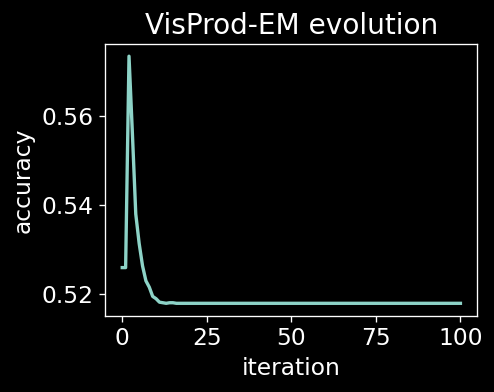

In [33]:
metric = 'accuracy'
# metric = 'log-likelihood'
# -----------------------------
plt.figure(figsize=(4,3))
VisProd_EM_evolution[metric].plot(ax=plt.gca(), linewidth=2)
plt.ylabel(metric)
plt.title("VisProd-EM evolution");

In [34]:
Y_VisProdEM_preds = VisProd_EM_shift_probs.argmax(1)
Y_VisProdEM_preds

array([14, 13, 13, ...,  8,  0,  8], dtype=int64)

In [35]:
phase = 'test'

y = Y_comb[phase]
y_pred = Y_VisProdEM_preds
true_pos = pd.Series(y[y==y_pred]).value_counts()
label_dists_df[f'VisProd-EM: {phase} soft pred prior'] = pd.Series(VisProd_EM_shift_probs.mean(0))
label_dists_df[f'VisProd-EM: {phase} true pos'] = true_pos
label_dists_df[f'VisProd-EM: {phase} acc'] = label_dists_df[f'VisProd-EM: {phase} true pos'] / label_dists_df[f'{phase} samples']
label_dists_df

,shape,color,global samples,global freq,shape idx,color idx,train samples,train freq,val samples,val freq,...,state,VisProd: train soft pred prior,VisProd: train true pos,VisProd: train acc,VisProd: test soft pred prior,VisProd: test true pos,VisProd: test acc,VisProd-EM: test soft pred prior,VisProd-EM: test true pos,VisProd-EM: test acc
comb idx,,,,,,,,,,,,,,,,,,,,,
0,cube,blue,7520,0.041778,0,0,6841.0,0.084501,373,0.079735,...,seen,0.114336,5644.0,0.825026,0.088180,249.0,0.813725,6.137061e-02,261.0,0.852941
1,cube,brown,7508,0.041711,0,1,6790.0,0.083871,376,0.080376,...,seen,0.018398,1178.0,0.173490,0.063360,276.0,0.807018,6.687705e-02,301.0,0.880117
2,cube,cyan,7344,0.040800,0,2,NaN,NaN,5,0.001069,...,unseen,0.000009,NaN,NaN,0.000016,NaN,NaN,4.862232e-40,NaN,NaN
3,cube,gray,7552,0.041956,0,3,6793.0,0.083908,405,0.086575,...,seen,0.096982,6506.0,0.957751,0.089089,341.0,0.963277,8.833158e-02,341.0,0.963277
4,cube,green,7346,0.040811,0,4,6611.0,0.081660,390,0.083369,...,seen,0.095520,6604.0,0.998941,0.144574,345.0,1.000000,5.728751e-02,240.0,0.695652
5,cube,purple,7565,0.042028,0,5,NaN,NaN,5,0.001069,...,unseen,0.000599,NaN,NaN,0.007780,36.0,0.120000,2.463866e-02,100.0,0.333333
6,cube,red,7458,0.041433,0,6,NaN,NaN,5,0.001069,...,unseen,0.000076,NaN,NaN,0.005022,19.0,0.063333,1.505797e-02,30.0,0.100000
7,cube,yellow,7707,0.042817,0,7,NaN,NaN,5,0.001069,...,unseen,0.000538,NaN,NaN,0.035545,124.0,0.413333,1.115360e-01,261.0,0.870000
8,cylinder,blue,7338,0.040767,1,0,6658.0,0.082240,382,0.081659,...,seen,0.079468,4853.0,0.728898,0.053722,221.0,0.741611,2.080930e-02,102.0,0.342282


## Calibration

In [36]:
# multi_class = 'ovr'
# multi_class = 'multinomial'
# multi_class = 'none'

max_iter=1000 # default: 100
# ------------------------------

if args.VP_calibrate:
    for phase in phases:
        Y_VisProd_probs[f'{phase}_calib'] = np.zeros_like(Y_VisProd_probs[phase])
        Y_comb_VP[f'{phase}_calib'] = Y_comb_VP[phase]

    for i_comb in tqdm(range(Y_VisProd_probs['held-out'].shape[1])):
        y = (Y_comb_VP['held-out'] == i_comb)
        if y.sum() > 0: # can calibrate only if i_comb is seen - contains samples
            calibrator = LogisticRegression(penalty='none', max_iter=max_iter)
            calibrator.fit(X=Y_VisProd_probs['held-out'][:,i_comb].reshape(-1, 1), y=y)
        
        for phase in phases:
            if y.sum() > 0:
                Y_VisProd_probs[f'{phase}_calib'][:,i_comb] = calibrator.predict_proba(
                    Y_VisProd_probs[phase][:,i_comb].reshape(-1, 1))[:,1]
            else:
                Y_VisProd_probs[f'{phase}_calib'][:,i_comb] = Y_VisProd_probs[phase][:,i_comb]
    
    for phase in ['train', 'test']:
        y = Y_comb_VP[f'{phase}_calib']
        y_pred = Y_VisProd_probs[f'{phase}_calib'].argmax(1)
        true_pos = pd.Series(y[y==y_pred]).value_counts()
        label_dists_df[f'calib VisProd: {phase} acc'] = label_dists_df[f'VisProd: {phase} true pos'] / label_dists_df[f'{phase} samples']
    # display(label_dists_df)

100%|██████████| 24/24 [00:00<00:00, 144.99it/s]


## Calib. VisProd-EM

In [37]:
EM_iterations = 100
# EM_iterations = 10
# -------------------------------------

if args.VP_calibrate:
    prior_source = Y_VisProd_probs['train_calib'].mean(0)

    calib_VisProd_EM_evolution, calib_VisProd_EM_shift_probs = basic_EM(Y=Y_comb_VP['test_calib'],
                                                        Y_probs=Y_VisProd_probs['test_calib'],
                                                        prior_source = prior_source,
                                                        EM_iterations=EM_iterations)

100%|██████████| 100/100 [00:00<00:00, 221.11it/s]


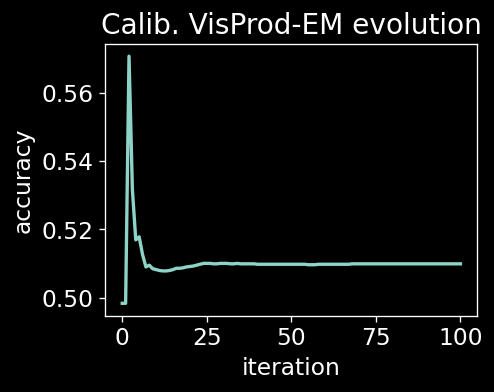

In [38]:
metric = 'accuracy'
# metric = 'log-likelihood'
# -----------------------------

if args.VP_calibrate:
    plt.figure(figsize=(4,3))
    calib_VisProd_EM_evolution[metric].plot(ax=plt.gca(), linewidth=2)
    plt.ylabel(metric)
    plt.title("Calib. VisProd-EM evolution")

In [39]:
if args.VP_calibrate:
    phase = 'test'

    y = Y_comb_VP[phase]
    y_pred = calib_VisProd_EM_shift_probs.argmax(1)
    true_pos = pd.Series(y[y==y_pred]).value_counts()
    label_dists_df[f'calib VisProd-EM: {phase} soft pred prior'] = pd.Series(VisProd_EM_shift_probs.mean(0))
    label_dists_df[f'calib VisProd-EM: {phase} true pos'] = true_pos
    label_dists_df[f'calib VisProd-EM: {phase} acc'] = label_dists_df[f'calib VisProd-EM: {phase} true pos'] / label_dists_df[f'{phase} samples']

# Summary

In [40]:
core_result_cols = [col for col in label_dists_df.columns if 'acc' in col]
result_cols = label_cols + ['state', 'train freq', 'test freq'] + core_result_cols

results_df = label_dists_df[result_cols]
# results_df = results_df.sort_values(by='train freq', ascending=False)
with pd.option_context('display.float_format',"{:,.3%}".format):
    display(results_df)

,shape,color,state,train freq,test freq,VisProd: train acc,VisProd: test acc,VisProd-EM: test acc,calib VisProd: train acc,calib VisProd: test acc,calib VisProd-EM: test acc
comb idx,,,,,,,,,,,
0,cube,blue,seen,8.450%,3.964%,82.503%,81.373%,85.294%,82.503%,81.373%,85.294%
1,cube,brown,seen,8.387%,4.430%,17.349%,80.702%,88.012%,17.349%,80.702%,91.228%
2,cube,cyan,unseen,NaN,3.886%,NaN,NaN,NaN,NaN,NaN,NaN
3,cube,gray,seen,8.391%,4.585%,95.775%,96.328%,96.328%,95.775%,96.328%,96.610%
4,cube,green,seen,8.166%,4.469%,99.894%,100.000%,69.565%,99.894%,100.000%,67.536%
5,cube,purple,unseen,NaN,3.886%,NaN,12.000%,33.333%,NaN,12.000%,33.667%
6,cube,red,unseen,NaN,3.886%,NaN,6.333%,10.000%,NaN,6.333%,10.000%
7,cube,yellow,unseen,NaN,3.886%,NaN,41.333%,87.000%,NaN,41.333%,87.000%
8,cylinder,blue,seen,8.224%,3.860%,72.890%,74.161%,34.228%,72.890%,74.161%,32.215%


In [41]:
with pd.option_context('display.float_format',"{:,.3%}".format):
    # display(results_df.groupby(by=label_cols).mean())
    display(results_df.groupby(by='color').mean())

,train freq,test freq,VisProd: train acc,VisProd: test acc,VisProd-EM: test acc,calib VisProd: train acc,calib VisProd: test acc,calib VisProd-EM: test acc
color,,,,,,,,
blue,8.352%,4.141%,84.360%,84.051%,70.827%,84.360%,84.051%,70.062%
brown,8.342%,4.188%,58.563%,90.351%,91.719%,58.563%,90.351%,87.840%
cyan,NaN,3.886%,NaN,NaN,NaN,NaN,NaN,NaN
gray,8.341%,4.603%,96.761%,96.966%,63.036%,96.761%,96.966%,94.413%
green,8.166%,4.080%,99.894%,64.500%,45.300%,99.894%,64.500%,44.623%
purple,8.317%,4.214%,99.955%,58.778%,50.285%,99.955%,58.778%,48.712%
red,8.252%,4.136%,100.000%,45.667%,58.534%,100.000%,45.667%,58.366%
yellow,8.502%,4.085%,99.942%,70.667%,84.974%,99.942%,70.667%,84.829%


In [42]:
core_result_dict = {}
for state in ['seen', 'unseen']:
    core_result_dict[state] = results_df.query(f"state == '{state}'")[core_result_cols].fillna(0).mean(0)
core_result_dict['all'] = results_df[core_result_cols].fillna(0).mean(0)
core_result_df = pd.DataFrame.from_dict(core_result_dict, orient='index')

acc_seen = core_result_df.loc['seen']
acc_unseen = core_result_df.loc['unseen']
core_result_df.loc['seen-unseen harmonic'] = 2*acc_seen*acc_unseen/(acc_seen+acc_unseen)

with pd.option_context('display.float_format',"{:,.1%}".format):
    display(core_result_df)

,VisProd: train acc,VisProd: test acc,VisProd-EM: test acc,calib VisProd: train acc,calib VisProd: test acc,calib VisProd-EM: test acc
seen,80.3%,85.6%,71.3%,80.3%,85.6%,69.7%
unseen,0.0%,15.3%,30.2%,0.0%,15.3%,30.2%
all,40.1%,50.4%,50.7%,40.1%,50.4%,50.0%
seen-unseen harmonic,0.0%,26.0%,42.4%,0.0%,26.0%,42.2%


# Comparison

In [43]:
# comparison_df = pd.read_excel('analysis\AO-Clevr 5000.xlsx')
# comparison_df = comparison_df.fillna(0)
# comparison_df

In [44]:
# y_col = 'full EM: test acc'
# # y_col = 'multi-class: test acc'
# # ---------------------------
# sns.lineplot(data=comparison_df, x='ratio', y=y_col, hue='state', marker="o")
# plt.legend(title='', frameon=False)
# plt.xscale('symlog', linthresh=1e-3)

# INTENTIONAL BREAK

In [45]:
raise RuntimeError("intentionally stopping here before next sections")

RuntimeError: intentionally stopping here before next sections

# MLP for multi-label combinations (CE)

## Net initialization

In [ ]:
device = torch_setup(deterministic=True)
seed_all(args.init_seed)

in_dim = X['train'].shape[1]
out_dim = len(global_label_combs)

assert in_dim == 512
Net_combs = nn.Sequential(
    nn.Linear(in_dim, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 64),
    nn.ELU(inplace=True),
    nn.Linear(64, out_dim),
)

net_combs = NeuralNetClassifier(
    Net_combs,
    max_epochs=20,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.SGD,
    lr=2e-1,
    batch_size=args.batch_size,
    iterator_train__shuffle=True,
    train_split=ValidSplit(cv=args.skorch_val_ratio, stratified=True),
    device=device,
    callbacks=[EpochScoring(scoring='accuracy', lower_is_better=False, on_train=True),
              ],
)
net_combs

## Training

In [ ]:
net_combs.fit(X['train'], Y_comb['train']);

## Evaluation

In [ ]:
Y_comb_probs = {phase: net_combs.predict_proba(X[phase]) for phase in ['train', 'test']}
for phase in ['train', 'test']:
#     assert set(np.unique(Y[phase])) == {0,1} # "EM below assumes labels are binary!"
    print(f"(Y_comb_probs[{phase}].sum(axis=1) - 1).mean(): %.12f"%(Y_comb_probs[phase].sum(axis=1) - 1).mean())
#     print(f"Y_comb_probs[{phase}].sum(axis=1)")
#     display(Y_comb_probs[phase].sum(axis=1))
    # assert (Y_comb_probs[phase].sum(axis=1) - 1).mean() == 0, 'EM requires probs (normalized)!'
Y_comb_probs['test']

In [ ]:
Y_comb_pred = {phase: Y_comb_probs[phase].argmax(axis=1) for phase in ['train', 'test']}
Y_comb_pred['test']

In [ ]:
for phase in ['train', 'test']:
    y = Y_comb[phase]
    y_pred = Y_comb_pred[phase]
    true_pos = pd.Series(y[y==y_pred]).value_counts()
    label_dists_df[f'multi-class: {phase} soft pred prior'] = pd.Series(Y_comb_probs[phase].mean(0))
    label_dists_df[f'multi-class: {phase} true pos'] = true_pos
    label_dists_df[f'multi-class: {phase} acc'] = label_dists_df[f'multi-class: {phase} true pos'] / label_dists_df[f'{phase} samples']
label_dists_df

In [ ]:
result_cols = ['train freq', 'test freq', 'multi-class: train acc', 'multi-class: test acc']
results_df = label_dists_df[result_cols].sort_values(by='train freq', ascending=False)
results_df_styled = results_df.style.format("{:.1%}").background_gradient(cmap='Greens')
results_df_styled

In [ ]:
result_cols = label_cols + ['train freq', 'test freq', 'multi-class: train acc', 'multi-class: test acc']
results_df = label_dists_df[result_cols]
# results_df = results_df.sort_values(by='train freq', ascending=False)
with pd.option_context('display.float_format',"{:,.1%}".format):
    display(results_df)

In [ ]:
for phase in ['train', 'test']:
    print(f'multi-class combs net - {phase} soft predicted prior (mean of probs):')
    with pd.option_context('display.float_format',"{:,.3%}".format):
        display(label_dists_df.pivot(index='shape', columns='color', values=f'multi-class: {phase} soft pred prior'))

# Full EM

## Adding noise to unseen combs

In [ ]:
EM_meta_df = label_dists_df[['train freq', 'test freq']].copy()
EM_meta_df['mean test prob'] = Y_comb_probs['test'].mean(0)
EM_meta_df

In [ ]:
seen_mean_prob = EM_meta_df.loc[~EM_meta_df['train freq'].isna() ,'mean test prob'].mean()
unseen_mean_prob = EM_meta_df.loc[EM_meta_df['train freq'].isna() ,'mean test prob'].mean()
print("mean prob - seen, unseen = %.2e, %.2e"%(seen_mean_prob, unseen_mean_prob))

In [ ]:
# factor = np.ones_like(Y_comb_probs['test'])
# factor[:, label_dists_df['train freq'].isna().values] = 100
# factor[0][label_dists_df['train freq'].isna().values]

## EM

In [ ]:
EM_iterations = 100
# EM_iterations = 10

init_prior = 'source prior'
# init_prior = 'uniform'

prior_source_phase = 'est. soft train'
# prior_source_phase = 'est. soft test'
# prior_source_phase = 'true train'
# prior_source_phase = 'true test'
# prior_source_phase = 'uniform'

soft_prior = True # proper EM: SOFT prior_shift_pred = shift_probs.mean(axis=0)
# soft_prior = False # improper EM: HARD prior_shift_pred (calculated from hist)
over_update_probs = False # proper EM shift_probs = shift_probs_0 * prior_shift_pred / prior_train
# over_update_probs = True # improper EM shift_probs = shift_probs * prior_shift_pred / prior_train

n_combs = len(label_dists_df)
# -------------------------------------
    
if (not soft_prior) or over_update_probs or (prior_source_phase != 'est. soft train'):
    confirm_ui = input("confirm performing an IMPROPER EM for debugging, " \
        "(for a proper EM, set: soft_prior = True, over_update_probs = False, "\
        "prior_source_phase = 'est. soft train'): y/[n] ")
    if confirm_ui != 'y':
        raise RuntimeError("terminated by user")

if 'est. soft' in prior_source_phase:
    Y_probs_source = Y_comb_probs['test' if 'test' in prior_source_phase else 'train']
    prior_source = Y_probs_source.mean(axis=0)
elif 'true' in prior_source_phase:
    Y_source = Y_comb['test' if 'test' in prior_source_phase else 'train']
    hist = np.bincount(Y_source, minlength=n_combs)
    prior_source = hist / hist.sum()
elif prior_source_phase == 'uniform':
    prior_source = 1/n_combs * np.ones(n_combs)
else:
    raise NotImplementedError

print(f"source prior ('{prior_source_phase}'):")
display(prior_source)

# init
EM_results = pd.DataFrame(index=range(EM_iterations))
EM_results.index.name = 'iteration'
shift_labels = Y_comb['test']
shift_probs_0 = Y_comb_probs['test']
shift_probs = shift_probs_0

if init_prior == 'source prior':
    prior_shift_pred = prior_source
elif init_prior == 'uniform':
    prior_shift_pred = 1/n_combs * np.ones(n_combs)
else:
    raise NotImplementedError

# eval
shift_preds = shift_probs.argmax(axis=1)
positives = shift_preds==shift_labels
# EM_results.loc[0, [f'accuracy ({label})' for label in range(args.n_labels)]] = positives.mean(axis=0)
EM_results.loc[0, 'accuracy'] = positives.mean()
# likelihood
Y_true_pos_probs = np.take_along_axis(shift_probs, Y_comb['test'].reshape(-1,1), axis=1)
EM_results.loc[0, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

# EM
for i_EM in tqdm(range(1, 1+EM_iterations)):        
    # E-step
    if over_update_probs:
        shift_probs = shift_probs * prior_shift_pred / prior_source
    else:
        shift_probs = shift_probs_0 * prior_shift_pred / prior_source
    shift_probs = (shift_probs.T / shift_probs.sum(axis=1)).T
    
    shift_preds = shift_probs.argmax(axis=1)
    
    # eval
    positives = shift_preds==shift_labels
    EM_results.loc[i_EM, 'accuracy'] = positives.mean()
    # likelihood
    Y_true_pos_probs = np.take_along_axis(shift_probs, Y_comb['test'].reshape(-1,1), axis=1)
    EM_results.loc[i_EM, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

    # M-step
    if soft_prior:
        prior_shift_pred = shift_probs.mean(axis=0)
    else:
        hist_shift_pred = np.bincount(shift_preds, minlength=args.n_classes_per_label * args.n_labels)
        prior_shift_pred = hist_shift_pred / hist_shift_pred.sum()

assert (~np.isfinite(shift_probs)).sum() == 0
# full_EM_evolution, full_EM_shift_probs = EM(Y=Y_comb, Y_probs=Y_comb_probs, EM_iterations=EM_iterations,
#     prior_source_phase=prior_source_phase, init_prior=init_prior, n_combs=len(label_dists_df),
#     soft_prior=soft_prior, over_update_probs=over_update_probs)
full_EM_evolution = EM_results
full_EM_shift_probs = shift_probs

In [ ]:
label_dists_df['full EM: test pred prior'] = pd.Series(full_EM_shift_probs.mean(0))
print('full EM - test predicted test prior:')
with pd.option_context('display.float_format',"{:,.1e}".format):
    display(label_dists_df.pivot(index='shape', columns='color',
    values='full EM: test pred prior'))

In [ ]:
# metric = 'accuracy'
metric = 'log-likelihood'
# -----------------------------
plt.figure(figsize=(4,3))
full_EM_evolution[metric].plot(ax=plt.gca(), linewidth=2)
plt.ylabel(metric)
plt.title("full EM evolution");

In [ ]:
full_EM_preds = full_EM_shift_probs.argmax(axis=1)

In [ ]:
for phase in ['test']:
    y = Y_comb[phase]
    y_pred = full_EM_preds
    true_pos = pd.Series(y[y==y_pred]).value_counts()
    label_dists_df[f'full EM: {phase} true pos'] = true_pos
    label_dists_df[f'full EM: {phase} acc'] = label_dists_df[f'multi-class: {phase} true pos'] / label_dists_df[f'{phase} samples']
label_dists_df